In [46]:
# Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import os
import sys
!{sys.executable} -m pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: C:\Users\nnaji\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [47]:
#specify the learning rate
learning_rate = 0.0005
#The learning rate has to do with the 
curr_dir = os.getcwd()
print(curr_dir)


# Load Dataset
df = pd.read_csv('BigData.csv')

#This portion of the code specifies the learning rate. 


c:\Users\nnaji\OneDrive\Documents\GitHub\UGRA_LSTM_Solar-Prediction\Homework2_baseline


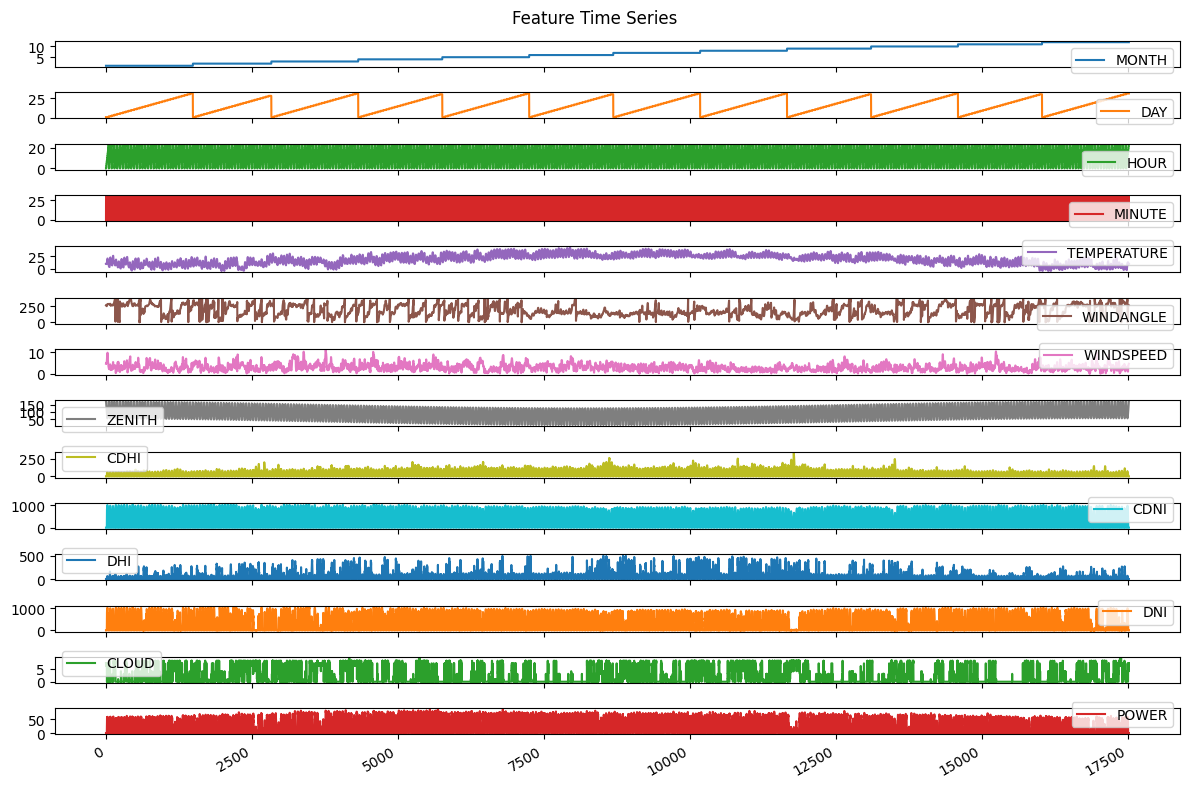

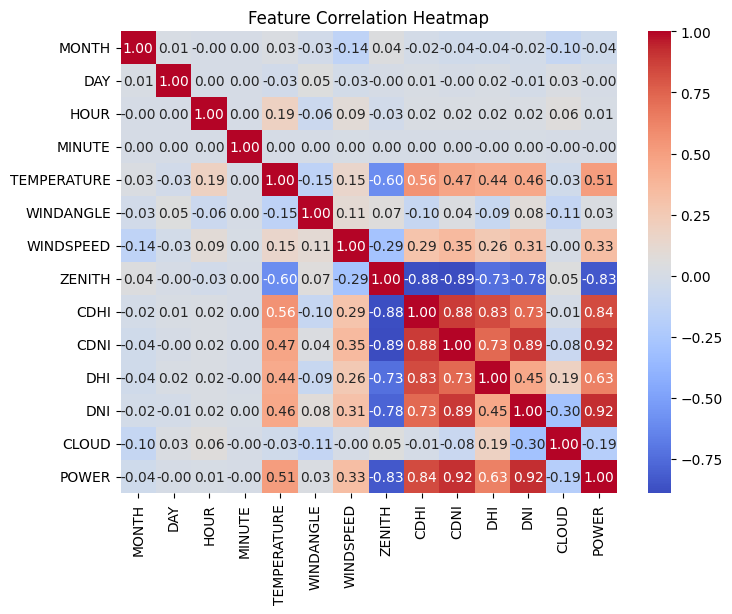

ImportError: cannot import name 'find_stack_level' from 'pandas.util._exceptions' (C:\Users\nnaji\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\util\_exceptions.py)

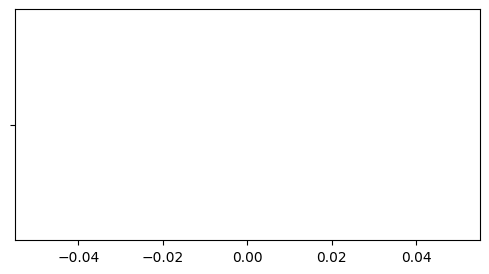

In [48]:
#Time Series Line Plot
df.plot(subplots=True, figsize=(12, 8), title="Feature Time Series")
plt.tight_layout()
plt.show()

#Correlation Heatmap
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

#Boxplot for Identifying Outliers
for col in df.columns:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()
#At this point, outliers in the data are checked for. The data is completely free of outliers and does not need to be extravagantly normalized. We are
#clear to utilize the MinMaxScalar

C:\Users\nnaji\AppData\Local\Temp\ipykernel_16080\91896444.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', num_features)  # 'tab20' provides up to 20 distinct colors


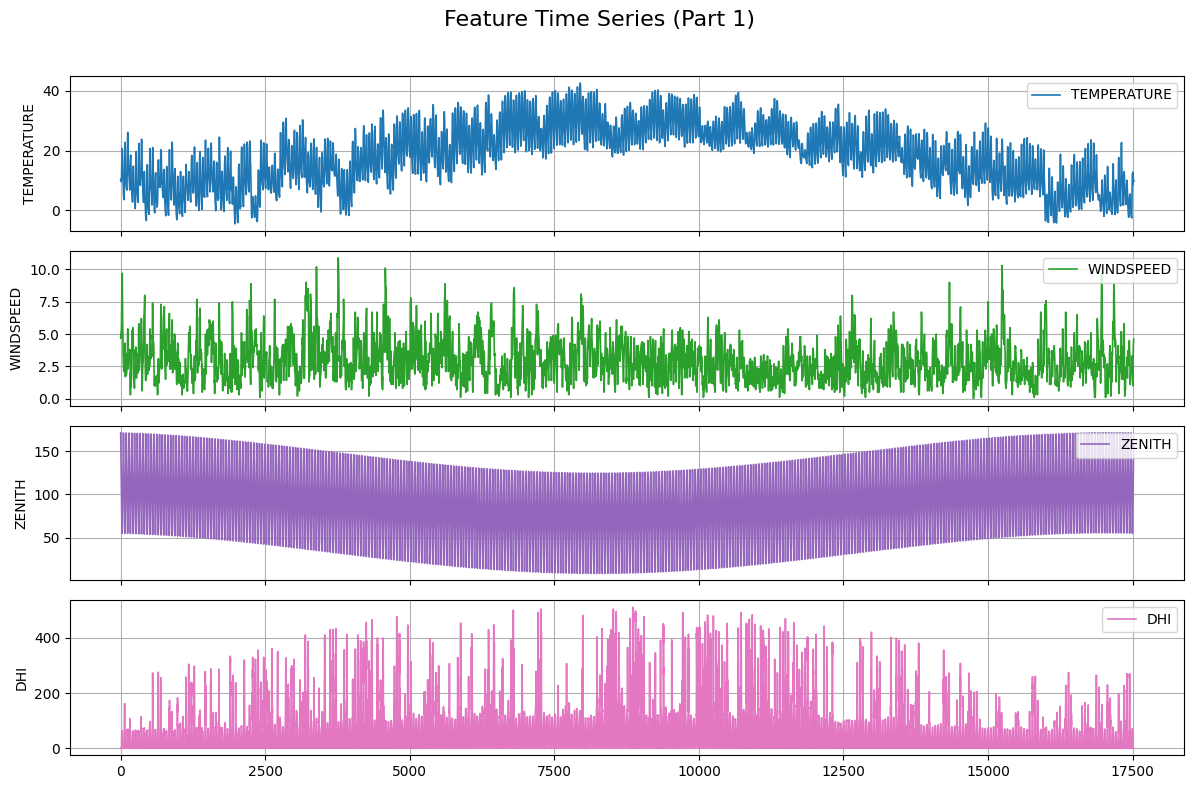

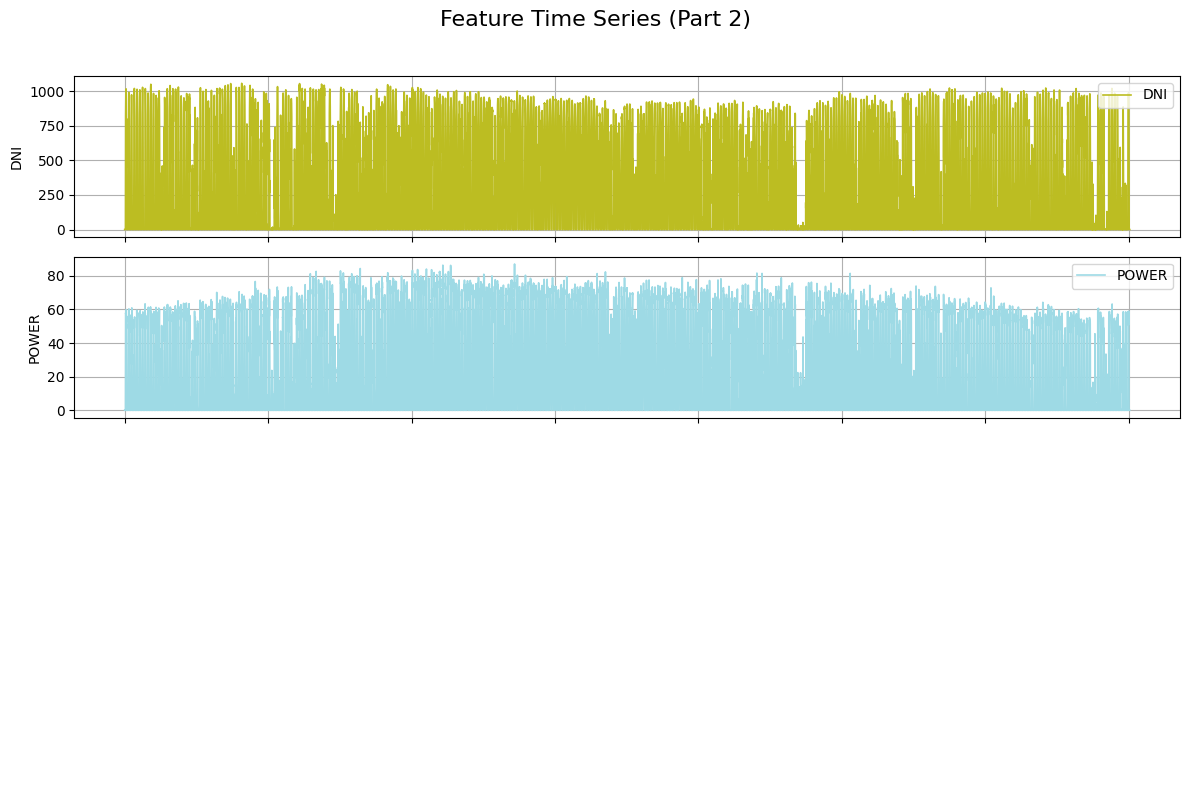

In [49]:
#plotted the features to make sure there are not missing data points. 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Load your dataset
df = pd.read_csv('MedData.csv')  # or your actual filename

# Parameters
features_per_fig = 4
num_features = len(df.columns)
num_figs = (num_features + features_per_fig - 1) // features_per_fig

# Generate a color map
colors = cm.get_cmap('tab20', num_features)  # 'tab20' provides up to 20 distinct colors

# Plot
for i in range(num_figs):
    fig, axs = plt.subplots(features_per_fig, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f"Feature Time Series (Part {i+1})", fontsize=16)

    for j in range(features_per_fig):
        idx = i * features_per_fig + j
        if idx >= num_features:
            axs[j].axis('off')
            continue
        col = df.columns[idx]
        axs[j].plot(df[col], label=col, linewidth=1.2, color=colors(idx))
        axs[j].set_ylabel(col)
        axs[j].legend(loc='upper right')
        axs[j].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [50]:
# Separate Prediction Variable
solar_Xdata = df.copy()
solar_ydata = solar_Xdata.pop("POWER")


# Reshape Data
solar_Xdata = solar_Xdata.values.reshape(-1,solar_Xdata.shape[1])
solar_ydata = solar_ydata.values.reshape(-1,1)

In [51]:
# Normalize Data
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

solar_XdataN = X_scaler.fit_transform(solar_Xdata)
solar_ydataN = y_scaler.fit_transform(solar_ydata)

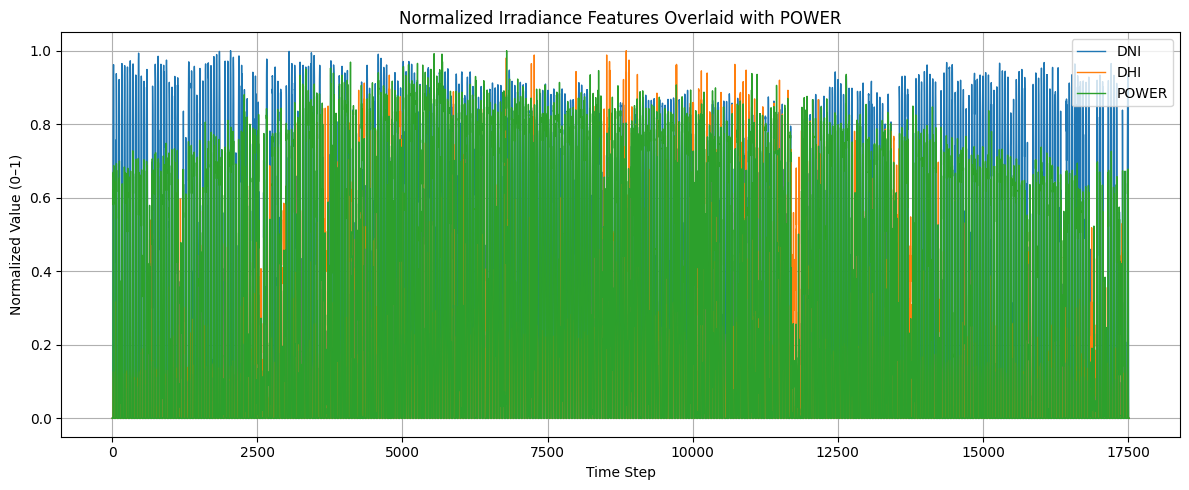

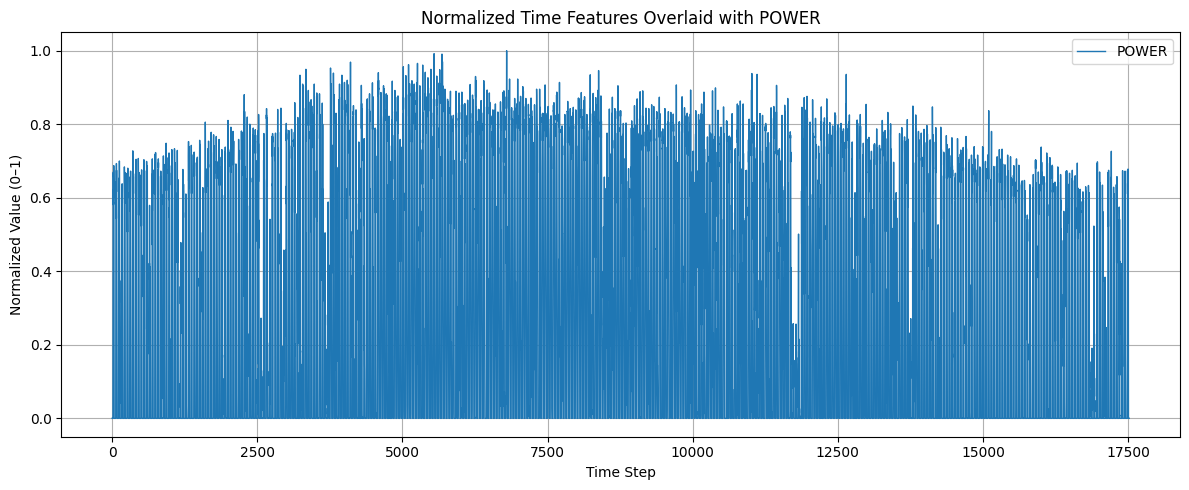

In [ ]:
import matplotlib.pyplot as plt

# Convert scaled arrays back to DataFrame for plotting
normalized_df = pd.DataFrame(solar_XdataN, columns=[col for col in df.columns if col != 'POWER'])
normalized_df['POWER'] = solar_ydataN

# Overlay Plot: Irradiance vs. Power
plt.figure(figsize=(12, 5))
for col in ['DNI', 'DHI', 'CDNI', 'CDHI', 'POWER']:
    if col in normalized_df.columns:
        plt.plot(normalized_df[col], label=col, linewidth=1)

plt.title("Normalized Irradiance Features Overlaid with POWER")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value (0–1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# This plot shows how different sunlight-related features (DNI, DHI, CDNI, CDHI) 
# change over time along with solar power (POWER).
# If the model is learning correctly, solar power should increase when sunlight increases.
# This helps verify that irradiance features are meaningful inputs for prediction.


# Overlay Plot: Time Features vs. Power
plt.figure(figsize=(12, 5))
for col in ['HOUR', 'DAY', 'MONTH', 'POWER']:
    if col in normalized_df.columns:
        plt.plot(normalized_df[col], label=col, linewidth=1)

plt.title("Normalized Time Features Overlaid with POWER")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value (0–1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# This plot shows how solar power changes throughout the day (HOUR), across days (DAY), and months (MONTH).
# Solar power usually peaks around midday (HOUR), and this pattern should be visible.
# It confirms that time-based features help the model understand daily and seasonal cycles.

In [54]:
# Create Sequences
X, y = [], []
for i in range(24, len(solar_ydataN)):
    #This is the selected feautres that are going to be used. 
     X.append(solar_XdataN[i-24:i,:])
     y.append(solar_ydataN[i, 0])  # Add the corresponding target
X, y = np.array(X), np.array(y)

#this is a quick check for the sequence lengths
print("X shape:", X.shape)
print("y shape:", y.shape)


# Split data into training and testing sets
train_size = int(0.8 * len(y))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM layer
##X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
##X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))


X shape: (17496, 24, 5)
y shape: (17496,)


In [56]:
# Build LSTM Model
solar_model = Sequential()
solar_model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
solar_model.add(LSTM(units = 50))
solar_model.add(Dense(units=1))

# Create Model
# set Epoch number
setEpoch = 50

# create the optimizer with the desired learning rate
adam_optimizer = Adam(lr = learning_rate)
solar_model.compile(optimizer=adam_optimizer, loss='mean_absolute_error')
solar_model.fit(X_train, y_train, epochs = setEpoch, batch_size = 32)

Epoch 1/50
438/438 [==============================] - 9s 14ms/step - loss: 0.0923
Epoch 2/50
438/438 [==============================] - 6s 14ms/step - loss: 0.0580
Epoch 3/50
438/438 [==============================] - 8s 18ms/step - loss: 0.0526
Epoch 4/50
438/438 [==============================] - 8s 18ms/step - loss: 0.0486
Epoch 5/50
438/438 [==============================] - 7s 17ms/step - loss: 0.0480
Epoch 6/50
438/438 [==============================] - 7s 16ms/step - loss: 0.0458
Epoch 7/50
438/438 [==============================] - 7s 17ms/step - loss: 0.0452
Epoch 8/50
438/438 [==============================] - 8s 17ms/step - loss: 0.0445
Epoch 9/50
438/438 [==============================] - 8s 18ms/step - loss: 0.0437
Epoch 10/50
438/438 [==============================] - 8s 18ms/step - loss: 0.0426
Epoch 11/50
438/438 [==============================] - 8s 19ms/step - loss: 0.0421
Epoch 12/50
438/438 [==============================] - 7s 17ms/step - loss: 0.0423
Epoch 13/50
4

110/110 [==============================] - 1s 5ms/step


Text(0.02, 0.5, 'DC Power [MW]')

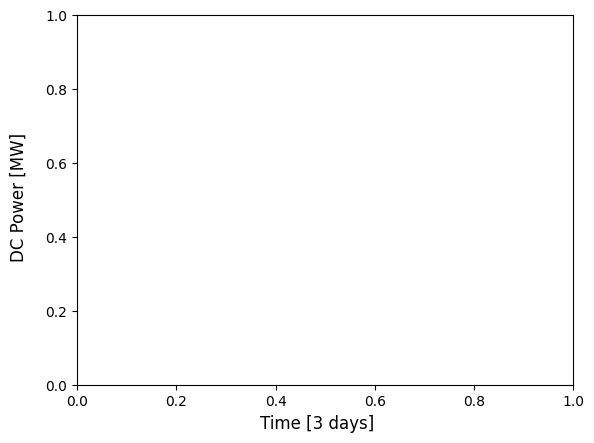

In [ ]:
# Run Prediction
y_pred = solar_model.predict(X_test)
y_pred_orig = y_scaler.inverse_transform(y_pred)
y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1,1))

# Display / Graph
# Figure labels
fig, axs = plt.subplots()
fig.supxlabel("Time [3 days]")
fig.supylabel("DC Power [MW]")
axs.plot(y_test_orig[0:150], label="Actual")
axs.plot(y_pred_orig[0:150], label="Predicted")
axs.legend()

In [ ]:
# Evaluate Error
mae = mean_absolute_error(y_test_orig, y_pred_orig)

# Display
axs.plot(y_test_orig[0:150])
axs.plot(y_pred_orig[0:150])

# Title Graph with Epochs and Error
title = "Train From " + str(solar_Xdata.shape[1]) + " Inputs\n" + "Epochs: " + str(setEpoch) + ". Avg MAE Error: " + str(f"{mae:.2f}")
fig.suptitle(title)

# Save Graph as PNG
filename = "Inputs_" + str(solar_Xdata.shape[1]) + "_Epochs_" + str(setEpoch)
filepath = 'Images/'
plt.savefig(curr_dir + "\\" +filename)
plt.show()